# Explaining classifier predictions

In this notebook we will look into the contribution of individual features to a classifier's prediction. To demonstrate, we will implement a simple baseline for [SNLI](https://nlp.stanford.edu/projects/snli/). 

We will use the following tools:

## 1. LIME:

Lime can be used to explain any black box classifier, with two or more classes. The only requirement is for the classifier to implement a `predict_proba` function that takes in a numpy array and outputs a probability for each class (following the Scikit Learn interface). LIME can be installed from [PyPI](https://pypi.org/project/lime/):

```
pip install lime
```

or [conda-forge](https://anaconda.org/conda-forge/lime)

```
conda install -c conda-forge lime
```

## 2. SHAP:

SHAP (SHapley Additive exPlanations) is based on game theory and is used to analyze additive feature attribution method based on expectations. 

### Installation

SHAP can be installed from [PyPI](https://pypi.org/project/shap/):

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

The notebook is based on the materials from the [Explainable AI workshop](https://www.appliedmldays.org/workshops/explainable-ai-how-to-demystify-machine-learning-models) in AMLD 2019. 

## Load dependencies

In [1]:
import os
import lime
import shap
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

shap.initjs()

## Load the data

First, let's download and load SNLI.

In [2]:
if not os.path.exists('snli_1.0'):
    !wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
    !unzip snli_1.0.zip

In [3]:
import json
import codecs
import logging

from itertools import count
from tqdm import tqdm_notebook
from collections import defaultdict

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


class DatasetReader:
    """
    A class for reading and processing a dataset in the SNLI format
    """
    def __init__(self, dataset_file, label2index=None):
        """
        Read the dataset and
        :param dataset_file: a json file in which each example contains the 
        fields `sentence1` (premise), `sentence2` (hypothesis) and `gold_label`
        :param label2index: the label dictionary (provide for loading test and validation)
        """
        instances = []
        labels = []

        # Get the labels
        created_labels = False
        if label2index is None:
            label2index = defaultdict(lambda c=count(): next(c))
            created_labels = True

        logger.info('Reading {}...'.format(dataset_file))
        with codecs.open(dataset_file, 'r', 'utf-8') as f_in:
            for line in tqdm_notebook(f_in):
                example = json.loads(line.strip())
                premise, hypo = example['sentence1'], example['sentence2']
                label = example['gold_label']
                
                # Skip undecided
                if label == '-':
                    continue
                    
                instances.append((premise, hypo))
                labels.append(label2index[label])

        self.instances = instances
        self.labels = labels
        self.label2index = label2index
        self.index2label = [label for label, index in sorted(label2index.items(), key=lambda x: x[1])]
        self.instance_ids = []

        if created_labels:
            logger.info('{} labels: {}'.format(len(self.label2index), self.label2index))

            
data_dir = 'snli_1.0'
train = DatasetReader(os.path.join(data_dir, 'snli_1.0_train.jsonl'))
test = DatasetReader(os.path.join(data_dir, 'snli_1.0_test.jsonl'), label2index=train.label2index)
val = DatasetReader(os.path.join(data_dir, 'snli_1.0_dev.jsonl'), label2index=train.label2index)

print('\n'.join(['\t'.join((premise, hypo, train.index2label[label])) 
                 for (premise, hypo), label in list(zip(train.instances, train.labels))[:10]]))


A person on a horse jumps over a broken down airplane.	A person is training his horse for a competition.	neutral
A person on a horse jumps over a broken down airplane.	A person is at a diner, ordering an omelette.	contradiction
A person on a horse jumps over a broken down airplane.	A person is outdoors, on a horse.	entailment
Children smiling and waving at camera	They are smiling at their parents	neutral
Children smiling and waving at camera	There are children present	entailment
Children smiling and waving at camera	The kids are frowning	contradiction
A boy is jumping on skateboard in the middle of a red bridge.	The boy skates down the sidewalk.	contradiction
A boy is jumping on skateboard in the middle of a red bridge.	The boy does a skateboarding trick.	entailment
A boy is jumping on skateboard in the middle of a red bridge.	The boy is wearing safety equipment.	neutral
An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts 

Loading the pre-trained word embeddings, specifically the 300d GloVe embeddings trained on Wikipedia and Gigaword. 

Note: there is a [much more efficient way](https://qr.ae/TUrK5i) to load word embeddings. Here we do it the standard way.

In [4]:
import gzip


def load_embeddings(file_name, vocab):
    """
    Load the pre-trained embeddings from a file
    :param file_name: the embeddings file
    :param vocab: limited vocabulary
    :return: the vocabulary and the word vectors
    """
    with gzip.open(file_name, 'rt', 'utf-8') as f_in:
        lines = [line.strip() for line in f_in]

    embedding_dim = len(lines[0].split()) - 1
    index2word = []
    vectors = []
    
    for line in lines:
        w, vector = line.split(' ', 1)
        if len(vector.split(' ')) == embedding_dim:
            if w in vocab:
                index2word.append(w)
                vectors.append(np.fromstring(vector, sep=' '))
                
    wv = np.vstack(vectors)
    return wv, index2word


LOCAL_EMB_PATH = os.path.expanduser('~/word_embeddings/glove/glove.6B.300d.txt.gz')
REMOTE_EMB_PATH = 'https://s3-us-west-2.amazonaws.com/allennlp/datasets/glove/glove.6B.300d.txt.gz'

if not os.path.exists(LOCAL_EMB_PATH):
    print(f'Downloading embeddings from {REMOTE_EMB_PATH}')
    local_dir = os.path.dirname(LOCAL_EMB_PATH)
    !mkdir -p $local_dir
    !wget $REMOTE_EMB_PATH -O $LOCAL_EMB_PATH

# Convert to IDs and limit the vocabulary
vocab = set()
instance_ids = []

for s in [train, test, val]:
    premises, hypos = zip(*s.instances)
    premise_words = [s.split() for s in premises]
    hypo_words = [s.split() for s in hypos]
    instance_ids.append(list(zip(premise_words, hypo_words)))
    vocab = vocab.union(set([w for s in premise_words + hypo_words for w in s]))
    vocab.add('unk')
    
print(f'Loading embeddings for vocabulary size: {len(vocab)}')

print(f'Loading embeddings from {LOCAL_EMB_PATH}')    
wv, index2word = load_embeddings(LOCAL_EMB_PATH, vocab)
word2index = {w:i for i, w in enumerate(index2word)}

Loading embeddings for vocabulary size: 64279
Loading embeddings from /home/nlp/vshwartz/word_embeddings/glove/glove.6B.300d.txt.gz


## Create the model

Inspired by the [hypothesis-only baseline for NLI paper](http://www.aclweb.org/anthology/S18-2023) we will define a very basic model that:

1. Embeds the words in the hypothesis with pre-trained GloVe embeddings.
2. Encodes the hypothesis words using an LSTM.
3. Predicts the label with an MLP that gets as input the hypothesis vector.

![title](hypo-only.png)

We will inherit from `sklearn.base.BaseEstimator` and use DyNet.

In [5]:
import math
import dynet_config

dynet_config.set(random_seed=0, mem=8)

import dynet as dy

from sklearn.base import BaseEstimator


NUM_LAYERS = 1
DISPLAY_FREQ = 1000
BATCH = 10 # For renew_cg during evaluation


class HypoOnlyBaseline(BaseEstimator):
    def __init__(self, wv, num_relations, word2index, model_dir=None):
        """
        Initialize the model
        :param wv: pre-trained word embedding vectors
        :param num_relations: the number of relations in the dataset
        :param word2index: a dictionary of words to their indices in the embeddings vocab
        :param model_dir: the directory where to save the model
        """
        self.wv = wv
        self.embeddings_dim = wv.shape[1]
        self.word2index = word2index
        self.UNK = word2index['unk']
        
        self.model_dir = model_dir
        self.num_relations = num_relations
        self.lookup = lambda w: dy.lookup(self.model_parameters['word_lookup'], w)

        if model_dir is not None:
            if not os.path.exists(model_dir):
                os.mkdir(model_dir)

        logger.info('Creating the model...')
        self.__create_computation_graph__()

    def fit(self, X, y, val_X=None, val_y=None, n_epochs=3, patience=1):
        """
        Train the model
        :param X: the train instances (list of hypotheses).
        :param y: the train labels.
        :param val_X: the validation instances, in the same format of the train. If given, the
                         training uses validation for early stopping.
        :param val_y: the validation labels. If given, the training uses validation for early stopping.
        :param n_epochs: number of training epochs.
        :param patience: how many epochs with no improvement on the loss to wait before stopping.
        """
        def validation_function():
            """
            Compute the loss on the validation set
            :return: the loss on the validation set
            """
            if val_X is None: return 0
            
            losses, curr_losses = [], []
            instances = 0
            W_w = self.model_parameters['W_w']

            for hypo, gold in zip(val_X, val_y):
                if instances % BATCH:
                    losses.append(dy.esum(curr_losses).value())
                    curr_losses = []
                    dy.renew_cg(immediate_compute=True, check_validity=True)
                    W_w = self.model_parameters['W_w']
                    
                hypo_vecs = self.__convert_text_to_indices__(hypo)
                predicted = self.__predict__(W_w, hypo_vecs)
                loss = dy.pickneglogsoftmax(predicted, gold)
                curr_losses.append(loss)
                instances += 1

            avg_loss = np.sum(losses) / len(losses)
            logger.info('Validation: Loss: {:.3f}'.format(avg_loss))
            return avg_loss

        logger.info('Training the model...')
        self.__train__(X, y, validation_function, n_epochs, patience)
        logger.info('Training is done!')

    def save_model(self, output_prefix):
        """
        Save the trained model to a file
        """
        if not os.path.exists(output_prefix):
            os.mkdir(output_prefix)

        save_to = output_prefix + '/model'
        self.model.save(save_to)
        
    def predict_proba(self, X):
        """
        Predict the label based on the hypothesis
        :param X: the instances to predict (list of hypotheses).
        :return a matrix with len(X) x num_labels softmax scores
        """
        dy.renew_cg(immediate_compute=True, check_validity=True)
        W_w = self.model_parameters['W_w']
        instances = [self.__convert_text_to_indices__(hypo) for hypo in X]
        distributions = [self.__predict__(W_w, hypo).npvalue() for hypo in instances]
        return np.vstack(distributions)

    def predict(self, X):
        """
        Predict the label based on the hypothesis
        :param X: the instances to predict. 
                Each instance is a list of word indices in the hypothesis.
        :return a vector of len(X) predicted lables
        """
        distributions = self.predict_proba(X)
        return np.argmax(distributions, axis=1)

    def __predict__(self, W_w, hypo):
        """
        Predict the label based on the hypothesis
        :param hypo: a list of word indices in the hypothesis
        :return a softmax distribution of the relation (DyNet parameter)
        """
        # Embed
        h_words = [self.lookup(w) for w in hypo]
        
        # Encode
        h_vec = self.builder.initial_state().transduce(h_words)[-1]
        
        # Predict
        out_vec = W_w * h_vec
        return dy.softmax(out_vec)
    
    def __convert_text_to_indices__(self, sentence):
        """
        Gets a sentence and returns a list of word indices.
        """
        return tuple([self.word2index.get(w, self.UNK) for w in sentence.split()])

    def __train__(self, X, y, validation_function, n_epochs, patience):
        """
        Train the model
        :param X: the train instances. Each instance is a list of word indices in the hypothesis.
        :param y: the train labels.
        :param validation_function: returns the validation set result
        :param n_epochs: the number of epochs.
        """
        trainer = dy.MomentumSGDTrainer(self.model)
        logger.info('Training with len(train) = {}'.format(len(X)))
        best_val_loss = np.infty
        patience_count = 0
        best_model = None

        for epoch in range(n_epochs):
            total_loss = 0.0
            epoch_indices = np.random.permutation(len(X)) 
            epoch_instances = [(X[i], y[i]) for i in epoch_indices]
            
            losses = []
            total_loss = 0
        
            for hypo, gold in tqdm_notebook(epoch_instances):
                dy.renew_cg(immediate_compute=True, check_validity=True)
                W_w = self.model_parameters['W_w']
                hypo_vecs = self.__convert_text_to_indices__(hypo)
                predicted = self.__predict__(W_w, hypo_vecs)
                loss = dy.pickneglogsoftmax(predicted, gold)
                losses.append(loss)
                loss_value = loss.value()
                
                if len(losses) % DISPLAY_FREQ == 0:
                    logger.info(
                        'Epoch {}/{}, instance {}/{}, Loss: {:.3f}'.format(
                            (epoch + 1), n_epochs, (len(losses) + 1), len(X), loss_value))
                
                loss.backward()
                trainer.update()
                total_loss += loss_value

            total_loss /= len(X)
            logger.info('Epoch {}/{}, Loss: {}'.format((epoch + 1), n_epochs, total_loss))

            # Early stopping
            curr_val_loss = validation_function()
            if best_val_loss >= curr_val_loss:
                patience_count = 0
                best_val_loss = curr_val_loss

                # Save the best model
                save_to = self.model_dir + '/{}'.format(epoch + 1)
                logger.info('Saving best model trained so far to {}'.format(save_to))
                self.save_model(save_to)
            else:
                patience_count += 1

            if patience_count == patience:
                logger.info('Lost patience, stopping training')
                previous_epochs = sorted([int(dirname) for dirname in os.listdir(self.model_dir)
                                  if os.path.isdir(os.path.join(self.model_dir, dirname))])
                last_saved_epoch = previous_epochs[-1]
                self.model.populate(os.path.join(self.model_dir, str(last_saved_epoch), 'model'))
                break
    
    def __create_computation_graph__(self):
        """
        Initialize the model
        """
        dy.renew_cg(immediate_compute=True, check_validity=True)
        self.model = dy.ParameterCollection()
        
        self.model_parameters = {}
        self.model_parameters['word_lookup'] = self.model.lookup_parameters_from_numpy(self.wv)
        self.model_parameters['W_w'] = self.model.add_parameters((self.num_relations, self.embeddings_dim))
        self.builder = dy.FastLSTMBuilder(NUM_LAYERS, self.embeddings_dim, self.embeddings_dim, self.model)
        
    @classmethod
    def load_model(cls, model_file_prefix, wv, num_relations):
        """
        Load the trained model from a file
        """
        classifier = HypoOnlyBaseline(wv, num_relations, model_dir=model_file_prefix)

        # Load the model
        load_from = model_file_prefix + '/model'
        logger.info('Loading the model from {}...'.format(load_from))
        classifier.model.populate(load_from)
        
        return classifier

For the sake of demonstration and to make the training faster, we will subsample the dataset, using only 10% of the data.

In [6]:
model_dir = 'hypo_only_model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    !rm -r hypo_only_model/*
    
UNK = word2index['unk']

num_relations = len(train.label2index)
train_size = math.ceil(len(train.labels) * 0.1)
X_train = list(zip(*train.instances))[1][:train_size]
y_train = train.labels[:train_size]
val_size = math.ceil(len(val.labels) * 0.1)
X_val = list(zip(*val.instances))[1][:val_size]
y_val = val.labels[:val_size]

In [7]:
model = HypoOnlyBaseline(wv, num_relations, word2index, model_dir=model_dir)
model.fit(X_train, y_train, X_val, y_val)

## Predict the validation set

In [8]:
val_pred = model.predict(X_val)
val_pred_text = [val.index2label[pred] for pred in val_pred]
val_pred_text[:20]

['neutral',
 'entailment',
 'contradiction',
 'contradiction',
 'neutral',
 'entailment',
 'contradiction',
 'neutral',
 'contradiction',
 'entailment',
 'contradiction',
 'neutral',
 'contradiction',
 'entailment',
 'entailment',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'neutral']

In [9]:
val_labels = y_val
val_labels_text = [val.index2label[label] for label in val_labels]
val_labels_text[:20]

['neutral',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'contradiction',
 'contradiction',
 'neutral',
 'entailment',
 'entailment',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'contradiction',
 'entailment',
 'contradiction']

In [10]:
report = classification_report(val_labels, val_pred, 
                               labels=range(len(train.index2label)), 
                               target_names=train.index2label)
print(report)

               precision    recall  f1-score   support

      neutral       0.62      0.58      0.60       328
contradiction       0.57      0.53      0.55       331
   entailment       0.55      0.62      0.58       326

    micro avg       0.58      0.58      0.58       985
    macro avg       0.58      0.58      0.58       985
 weighted avg       0.58      0.58      0.58       985



### Confusion matrix

Normalized confusion matrix


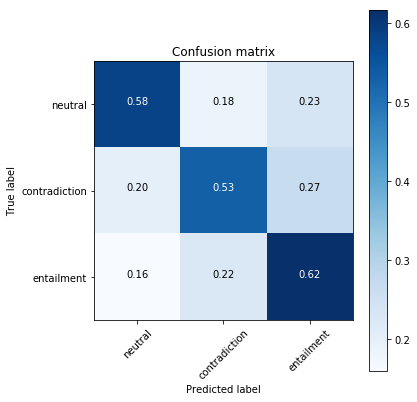

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
cnf_matrix = confusion_matrix(val_labels, val_pred)
plot_confusion_matrix(cnf_matrix, classes=train.index2label, title='Confusion matrix', normalize=True)

## Explaining the predictions

### 1. LIME

We need to create a `LimeTextExplainer` object, which expects the following arguments:

`class_names` - the labels (entailment, neutral, contradiction). Otherwise it will show 1, 2, 3 in the visualization.

`bow` - whether the representation is bag-of-words.

`split_expression` - a function that splits the text. Since SNLI is already tokenized, `str.split()` will do.

In [12]:
lime_explainer = LimeTextExplainer(class_names=train.index2label, 
                                   verbose=True, bow=False, 
                                   split_expression=lambda s: s.split())

### Predictions per label

LIME shows which features were the most influential in the model making a prediction. 

The explanations below show features each contributing to push the model output from the base value (the average model output over the training set) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [13]:
from tqdm import tqdm_notebook

# Predict the softmax distribution of classes
val_prob = model.predict_proba(X_val)
tp = (np.array(val_labels) - np.array(val_pred) == 0).nonzero()

In [14]:
sample = tp[0][:5]
all_labels = list(range(3))

for instance_index in tqdm_notebook(sample):
    print(f'Instance: {X_val[instance_index]}\nLabel: {val.index2label[val.labels[instance_index]]}')
    print("-----------------------------------")
    exp = lime_explainer.explain_instance(X_val[instance_index], 
                                          model.predict_proba, 
                                          labels=all_labels)
    
    exp.show_in_notebook()

Instance: The sisters are hugging goodbye while holding to go packages after just eating lunch.
Label: neutral
-----------------------------------
Intercept 0.36076670143045203
Prediction_local [1.07878905]
Right: 0.9999207258224487
Intercept 0.5273745012083713
Prediction_local [-0.04536813]
Right: 7.932398875709623e-05
Intercept 0.11012068413910932
Prediction_local [-0.03266676]
Right: 5.579702033742251e-09


Instance: Two woman are holding packages.
Label: entailment
-----------------------------------
Intercept 0.014422045084200922
Prediction_local [0.0022532]
Right: 0.0014402676606550813
Intercept 0.082872009991241
Prediction_local [0.02262852]
Right: 0.012585783377289772
Intercept 0.9027059248382502
Prediction_local [0.97511834]
Right: 0.9859739542007446


Instance: The men are fighting outside a deli.
Label: contradiction
-----------------------------------
Intercept 0.01860029642649177
Prediction_local [0.010949]
Right: 0.006091861054301262
Intercept 0.015120802584627224
Prediction_local [0.96909989]
Right: 0.9858567714691162
Intercept 0.9662788976170094
Prediction_local [0.01995111]
Right: 0.008051378652453423


Instance: Two kids at a ballgame wash their hands.
Label: neutral
-----------------------------------
Intercept -0.19602377757079048
Prediction_local [0.9064504]
Right: 0.8997734785079956
Intercept 0.6898134651239218
Prediction_local [0.21307809]
Right: 0.09974417090415955
Intercept 0.5062102936354811
Prediction_local [-0.11952847]
Right: 0.00048234505811706185


Instance: A woman drinks her coffee in a small cafe.
Label: contradiction
-----------------------------------
Intercept 0.27747762442325374
Prediction_local [-0.01180243]
Right: 0.001056379172950983
Intercept 0.23384824993046005
Prediction_local [1.13631968]
Right: 0.9988734126091003
Intercept 0.4886741469036421
Prediction_local [-0.12451728]
Right: 7.008340617176145e-05


Notice that the word *outside* contributes to `entailment` (it is a general word that is entailed by many words in the premises like *park*, *street*, etc.) and the word *woman* contributes to `contradiction` (most premises show either men or kids). 

We can also view the explanations in other formats:

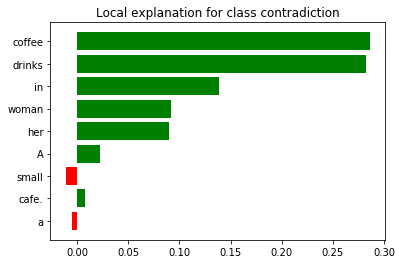

In [15]:
fig = exp.as_pyplot_figure(label=val.labels[instance_index])

In [16]:
exp.as_list(label=val.labels[instance_index])

[('coffee', 0.2862918428038598),
 ('drinks', 0.2820182939339741),
 ('in', 0.1389909013531708),
 ('woman', 0.09189242207994842),
 ('her', 0.08967352656504901),
 ('A', 0.022770849059546888),
 ('small', -0.011238648293900316),
 ('cafe.', 0.007474819272813445),
 ('a', -0.005402573906782688)]

### 2. SHAP

SHAP only supports specific types of models, so we will now create a max pooling bag-of-words random forest classifier for the hypothesis-only baseline. We can no longer analyze the individual words that contribute to the classification, but we will look at the coordinates in the embeddings that affect the decision.

In [17]:
from sklearn.ensemble import RandomForestClassifier


def sentence_to_bow(wv, word2index, sentence):
    """
    :param wv: pre-trained word embedding vectors
    :param word2index: a dictionary of words to their indices in the embeddings vocab
    :param sentence: sentence string
    """
    UNK = word2index['unk']
    indices = [word2index.get(w, UNK) for w in sentence.split()]
    vectors = [wv[i, :] for i in indices]
    bow = np.max(vectors, 0)
    return bow


X_train_for_rf = np.vstack([sentence_to_bow(wv, word2index, h) for h in X_train])
X_val_for_rf = np.vstack([sentence_to_bow(wv, word2index, h) for h in X_val])
rf_model = RandomForestClassifier(max_depth=10, n_estimators=20)

Train the model.

In [18]:
rf_model.fit(X_train_for_rf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predict the validation set.

In [19]:
val_pred_rf = rf_model.predict(X_val_for_rf)
val_pred_rf_text = [val.index2label[pred] for pred in val_pred_rf]
val_pred_rf_text[:20]

['neutral',
 'entailment',
 'contradiction',
 'contradiction',
 'neutral',
 'neutral',
 'contradiction',
 'neutral',
 'neutral',
 'contradiction',
 'contradiction',
 'neutral',
 'contradiction',
 'contradiction',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'entailment',
 'contradiction']

In [20]:
val_labels = y_val
val_labels_text = [val.index2label[label] for label in val_labels]
val_labels_text[:20]

['neutral',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'contradiction',
 'contradiction',
 'neutral',
 'entailment',
 'entailment',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'entailment',
 'neutral',
 'contradiction',
 'entailment',
 'contradiction']

In [21]:
print(classification_report(val_labels, val_pred_rf,
                            labels=range(len(train.index2label)), 
                            target_names=train.index2label))

               precision    recall  f1-score   support

      neutral       0.55      0.51      0.53       328
contradiction       0.50      0.47      0.49       331
   entailment       0.53      0.60      0.56       326

    micro avg       0.53      0.53      0.53       985
    macro avg       0.53      0.53      0.52       985
 weighted avg       0.53      0.53      0.52       985



This model performs worse than the LSTM-based model (which already perform worse than a model trained on all the data), but still well above the majority baseline ($F_1 = 0.33$).

Normalized confusion matrix


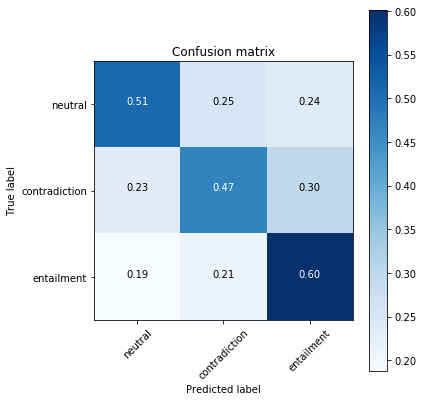

In [22]:
cnf_matrix_rf = confusion_matrix(val_labels, val_pred_rf)
plot_confusion_matrix(cnf_matrix_rf, classes=train.index2label, 
                      title='Confusion matrix', normalize=True)

In [23]:
# Load JS visualization code to notebook
shap.initjs()

# Explain the model's predictions using SHAP values
shap_explainer = shap.TreeExplainer(rf_model, X_train_for_rf)
shap_values = shap_explainer.shap_values(X_val_for_rf)

In [24]:
def plot_with_shap(instance_index):
    instance_text = X_val[instance_index]
    label = val.labels[instance_index]
    print(f'Instance: {instance_text}\nLabel: {val.index2label[label]}')
    print("-----------------------------------")
    bow_representation = sentence_to_bow(wv, word2index, instance_text)
    expected_value_for_label = shap_explainer.expected_value[label]
    shap_value_for_instance = shap_values[label][instance_index,:]

    return shap.force_plot(expected_value_for_label, 
                           shap_value_for_instance, 
                           bow_representation, 
                           feature_names=range(300))


plot_with_shap(sample[0])

Instance: The sisters are hugging goodbye while holding to go packages after just eating lunch.
Label: neutral
-----------------------------------


In [25]:
plot_with_shap(sample[1])

Instance: Two woman are holding packages.
Label: entailment
-----------------------------------


In [26]:
plot_with_shap(sample[2])

Instance: The men are fighting outside a deli.
Label: contradiction
-----------------------------------


It's difficult to draw conclusions from individual examples. 

### Visualizing multiple predictions

We can visualize several predictions with the same label. 

For example, we know that the existence of the word *cat* in the hypothesis correlates with `contradiction` (because many of the premises describe dog images, and, as you know, *cat* is the "opposite" of *dog*).  Can we find out which coordinates in the input capture cats?

If we choose "feature 85 effects" in both plots, you can see that it contributes negatively to entailment and positively to contradiction.

In [28]:
w = 'cat'
label = train.label2index['entailment']
ent_indices = [i for i, hypo in enumerate(X_val) if w in hypo and val_pred[i] == label] 
print(f'{len(ent_indices)} instances.')

shap.force_plot(shap_explainer.expected_value[label], 
                shap_values[label][ent_indices,:])

2 instances.


In [30]:
label = train.label2index['contradiction']
con_indices = [i for i, hypo in enumerate(X_val) if w in hypo and val_pred[i] == label] 
print(f'{len(con_indices)} instances.')

shap.force_plot(shap_explainer.expected_value[label], 
                shap_values[label][con_indices,:])

8 instances.


### Feature importance bar chart

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

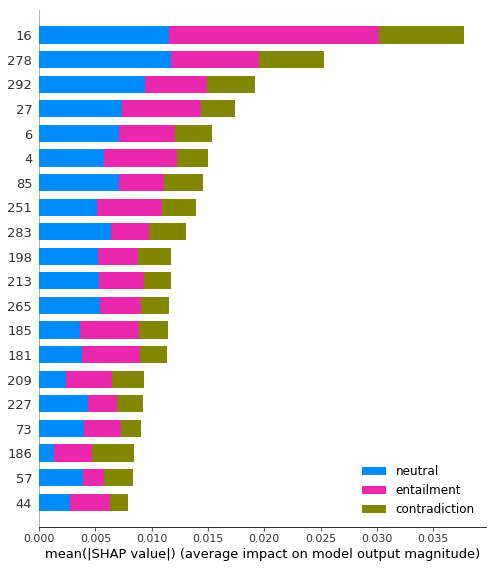

In [31]:
shap.summary_plot(shap_values, X_val_for_rf, 
                  plot_type='bar', 
                  feature_names=range(300), 
                  class_names=val.index2label)

### SHAP Dependence Plots

To understand how a single feature effects the output of the model we can plot the dependence plot. In this example we will choose feature 278 which was shown to be important for all labels. SHAP plots the value of the feature on the x-axis and its SHAP value on the y-axis. How much feature 278 impacts the prediction differs as shown by the vertical dispersion of data points. 

We set `interaction_index='auto'` to let SHAP pick the feature that seems to be the strongest interaction with feature 278. The coloring will show how much that other feature affects the prediction given a value of feature 278.

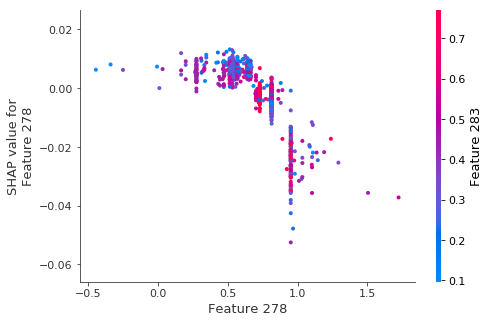

In [33]:
shap.dependence_plot(ind=278,
                     interaction_index='auto',
                     shap_values=shap_values[val.label2index['entailment']], 
                     features=X_val_for_rf)

We can see that very high and very low values of feature 278 yield more vertically-concentrated data points, hence they are less effected by other features. 

In addition, the most influential feature is 283, and the coloring shows that it tends to have a stronger effect on higher values of feature 181 than on its lower values (more red and less blue points). 